In [1]:
#| hide
%load_ext autoreload 
%autoreload 2 

# cheng2023TransRVNet

> Module that implements the models from [TransRVNet: LiDAR Semantic Segmentation With Transformer](https://ieeexplore.ieee.org/document/10056404).

**(UNDER CONSTRUCTION...)**

In [2]:
#| default_exp cheng2023TransRVNet

In [3]:
#| hide
from nbdev.showdoc import show_doc

In [4]:
#| export
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

# Complete architecture

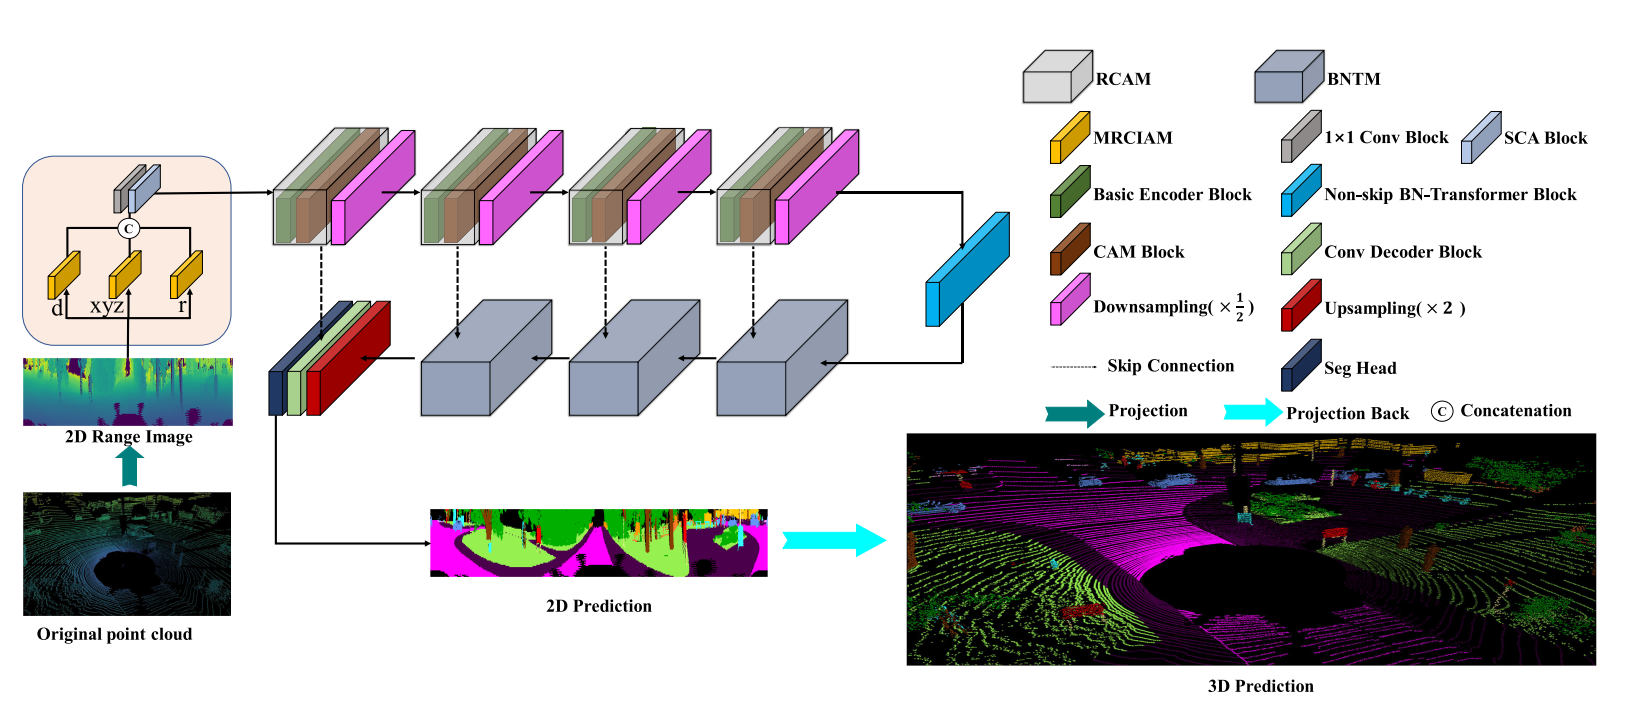

# Utils

In [5]:
#| export
class ConvBNPReLU(nn.Module):
    "Sequential composition of 2D convolution, batch normalization and PReLU."
    def __init__(self, 
                 in_channels:int,      # input channels size
                 out_channels:int,     # output channels size
                 kernel_size:int,
                 stride=1,
                 padding=0,
                 dilation=1
                )->torch.Tensor:  # ()
        super(ConvBNPReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation=dilation)
        self.batchNormalization = nn.BatchNorm2d(out_channels)
        self.activation = nn.PReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.batchNormalization(out)
        out = self.activation(out)
        return out

# MRCIAM

In [6]:
#|export 
class SACBlock(nn.Module):
    """Divides the input feature map into groups, integrating channel and spatial 
    attention for each group using the Shuffle Unit, aggregating all sub-features, 
    and finally using a channel shuffle operator to enable information exchange between different sub-features.
    """
    def __init__(self, 
                 channel:int,  # input channels size
                 groups=32
                )->torch.Tensor:
        super(SACBlock, self).__init__()
        self.groups = groups
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.cweight = nn.Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.cbias = nn.Parameter(torch.ones(1, channel // (2 * groups), 1, 1))
        self.sweight = nn.Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.sbias = nn.Parameter(torch.ones(1, channel // (2 * groups), 1, 1))

        self.sigmoid = nn.Sigmoid()
        self.gn = nn.GroupNorm(channel // (2 * groups), channel // (2 * groups))

    def channel_shuffle(self, x, groups):
        b, c, h, w = x.shape

        x = x.reshape(b, groups, -1, h, w)
        x = x.permute(0, 2, 1, 3, 4)

        # flatten
        x = x.reshape(b, -1, h, w)

        return x

    def forward(self, x): 
        b, c, h, w = x.shape

        # group into subfeatures
        x = x.reshape(b * self.groups, -1, h, w)

        # channel split
        x_0, x_1 = x.chunk(2, dim=1)

        # channel attention
        xn = self.avg_pool(x_0)
        xn = self.cweight * xn + self.cbias
        xn = x_0 * self.sigmoid(xn)

        # spatial attention
        xs = self.gn(x_1)
        xs = self.sweight * xs + self.sbias
        xs = x_1 * self.sigmoid(xs)

        # concatenate along channel axis
        out = torch.cat([xn, xs], dim=1)
        out = out.reshape(b, -1, h, w)

        # channel shuffle
        out = self.channel_shuffle(out, 2)
        return out

The SACBlock implementation is based on the code from TransRVNet's SalsaNext module.
Source: [TransRVNet's SalsaNext.py](https://github.com/huixiancheng/TransRVNet/blob/main/modules/SalsaNext.py)

More information about SCA block [SA-NET: SHUFFLE ATTENTION FOR DEEP CONVOLUTIONAL NEURAL NETWORKS](https://arxiv.org/pdf/2102.00240)

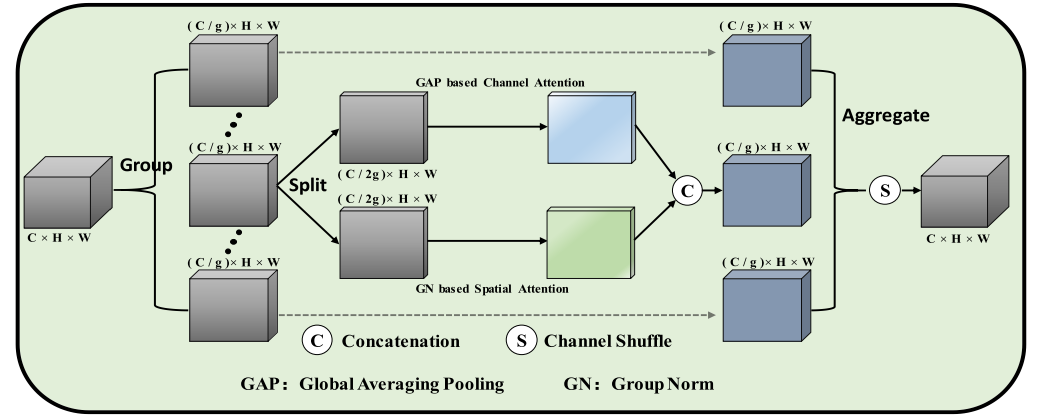

In [7]:
#| export
class MRCIAMSingleChannel(nn.Module):
    """
    Implementaton of MRCIAMSingleChannel (output is a hyper parameter).
    """
    def __init__(self, 
                 in_channels:int
                )->torch.Tensor: #
        super(MRCIAMSingleChannel, self).__init__()
        # Bloco 1
        self.block1_3x3 = ConvBNPReLU(in_channels, 1, kernel_size=3, padding=1)
        self.block1_5x5 = ConvBNPReLU(in_channels, 1, kernel_size=5, padding=2)
        self.block1_7x7 = ConvBNPReLU(in_channels, 1, kernel_size=7, padding=3)
        self.block1_3x3_2 = ConvBNPReLU(3, 32, kernel_size=3, padding=1)
        self.block1_1x1 = ConvBNPReLU(in_channels, 32, kernel_size=1)

        # Bloco 2
        self.block2_3x3 = ConvBNPReLU(32, 32, kernel_size=3, padding=1)
        self.block2_3x3_dilated = ConvBNPReLU(32, 64, kernel_size=3, padding=2, dilation=2)
        self.block2_1x1 = ConvBNPReLU(32, 64, kernel_size=1)

        # Bloco 3
        self.block3_3x3 = ConvBNPReLU(64, 64, kernel_size=3, padding=1)
        self.block3_5x5 = ConvBNPReLU(64, 64, kernel_size=5, padding=2)
        self.block3_7x7 = ConvBNPReLU(64, 64, kernel_size=7, padding=3)
        self.block3_3x3_2 = ConvBNPReLU(192, 128, kernel_size=3, padding=1)
        self.block3_1x1 = ConvBNPReLU(64, 128, kernel_size=1)

        # SCA Block
        self.sac_block = SACBlock(128)

    def forward(self, x):
        # Bloco 1
        conv1_3x3_out = self.block1_3x3(x)
        conv1_5x5_out = self.block1_5x5(x)
        conv1_7x7_out = self.block1_7x7(x)
        concat_out = torch.cat((conv1_3x3_out, conv1_5x5_out, conv1_7x7_out), 1)
        conv1_out = self.block1_3x3_2(concat_out)
        conv1x1_1_out = self.block1_1x1(x)
        block1_out = conv1_out + conv1x1_1_out

        # Bloco 2
        conv2_3x3_out = self.block2_3x3(block1_out)
        conv2_3x3_dilated_out = self.block2_3x3_dilated(conv2_3x3_out)
        conv1x1_out = self.block2_1x1(block1_out)
        block2_out = conv2_3x3_dilated_out + conv1x1_out

        # Bloco 3
        conv3_3x3_out = self.block3_3x3(block2_out)
        conv3_5x5_out = self.block3_5x5(block2_out)
        conv3_7x7_out = self.block3_7x7(block2_out)
        concat_out_2 = torch.cat((conv3_3x3_out, conv3_5x5_out, conv3_7x7_out), 1)
        conv3_out = self.block3_3x3_2(concat_out_2)
        conv1x1_6_out = self.block3_1x1(block2_out)
        block3_out = conv3_out + conv1x1_6_out

        # SAC Block
        out = self.sac_block(block3_out)

        return out

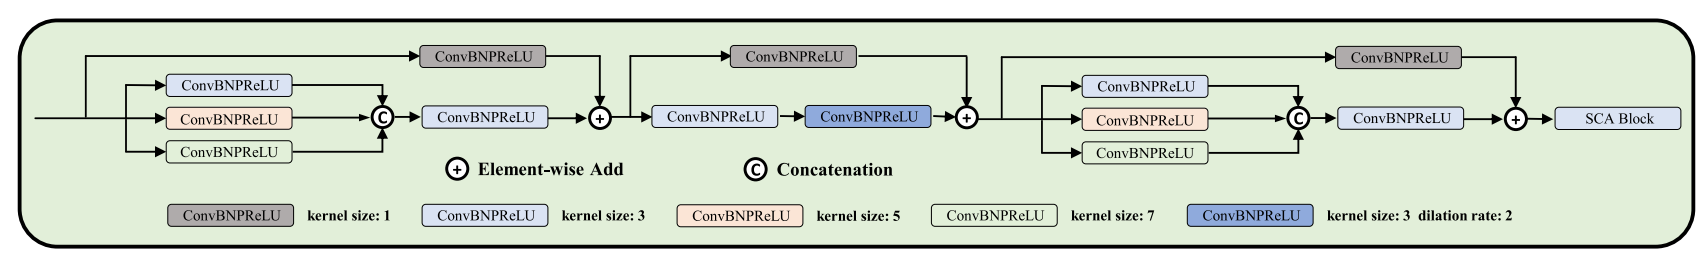

Here is an example on how to use it:

In [ ]:
model = MRCIAMSingleChannel(in_channels=1)

# Random Tensor representing input
input_tensor = torch.randn(4, 1, 32, 512)

output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([4, 128, 32, 512])


In [8]:
#|export 
class MRCIAM(nn.Module):
    """
    MRCIAM module is the agregation of 3 MRCIAMSingleChannel, each will compute
    3 input types, the xyz, reflectance and depth
    """
    def __init__(self
                )->torch.Tensor:
        super(MRCIAM, self).__init__()
        self.mrciam_depth_reflectance = MRCIAMSingleChannel(1)
        self.mrciam_xyz = MRCIAMSingleChannel(3)

        self.conv_1x1 = ConvBNPReLU(384, 384, kernel_size=1)

        # SCA Block
        self.sac_block = SACBlock(384)

    def forward(self, x1, x2, x3):
      mrciam_x1 = self.mrciam_depth_reflectance(x1)
      mrciam_x2 = self.mrciam_depth_reflectance(x2)
      mrciam_x3 =  self.mrciam_xyz(x3)

      concat_out = torch.cat((mrciam_x1, mrciam_x2, mrciam_x3), 1)

      conv_out = self.conv_1x1(concat_out)

      out = self.sac_block(conv_out)

      return out

Here is an example on how to use it:

In [ ]:
model = MRCIAM()

# Random Tensor representing depth and reflectance
input_tensor = torch.randn(4, 1, 32, 512)
# Random Tensor representing x, y, z
input_tensor2 = torch.randn(4, 3, 32, 512)

input_encoder = model(input_tensor, input_tensor, input_tensor2)
print("Output shape:", input_encoder.shape)

Output shape: torch.Size([4, 384, 32, 512])


# Encoder

In [9]:
#| export
class BasicEncoderBlock(nn.Module):
    """
    Basic block of encoder module
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int # output size returned by the BasicEncoderBlock
                )->torch.Tensor:  
        super(BasicEncoderBlock, self).__init__()
        self.conv1 = ConvBNPReLU(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = ConvBNPReLU(64, 64, kernel_size=3, padding=1)
        self.dilated_conv = ConvBNPReLU(64, 64, kernel_size=3, padding=2, dilation=2)

        self.residual_conv1 = ConvBNPReLU(256, out_channels, kernel_size=1)
        self.residual_conv2 = ConvBNPReLU(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # 3 ConvBNPReLU
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.dilated_conv(out2)

        # Concatanation
        concat_out = torch.cat((out1, out2, out3, out3), 1)

        # ConvBNPReLU of first concatenation
        out_residual1 = self.residual_conv1(concat_out)
        # ConvBNPReLU of input
        out_residual2 = self.residual_conv2(x)
        # Element-wise Add
        out = out_residual1 + out_residual2

        return out

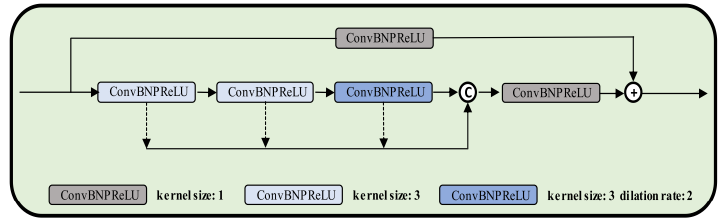

In [10]:
#| export
class CAM(nn.Module):
    """
    Context aggregation module
    """
    def __init__(self, 
                 inplanes:int
                )->int: # 
        super(CAM, self).__init__()
        self.pool = nn.MaxPool2d(7, 1, 3)
        self.Conv2d = nn.Conv2d(inplanes, inplanes // 16, kernel_size=1, stride=1)
        self.BatchNorm2d = nn.BatchNorm2d(inplanes // 16)
        self.Conv2d_2 = nn.Conv2d(inplanes // 16, inplanes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 7x7 pooling
        y = self.pool(x)
        # Conv2d and BatchNorm2d
        y = self.BatchNorm2d(self.Conv2d(y))
        # Conv2d_2 and Sigmoid
        y = self.sigmoid(self.Conv2d_2(y))
        # Element-wise Multiply
        return y * x

The CAM implementation is based on the code from TransRVNet's SalsaNext module.
Source: [TransRVNet's SalsaNext.py](https://github.com/huixiancheng/TransRVNet/blob/main/modules/SalsaNext.py)

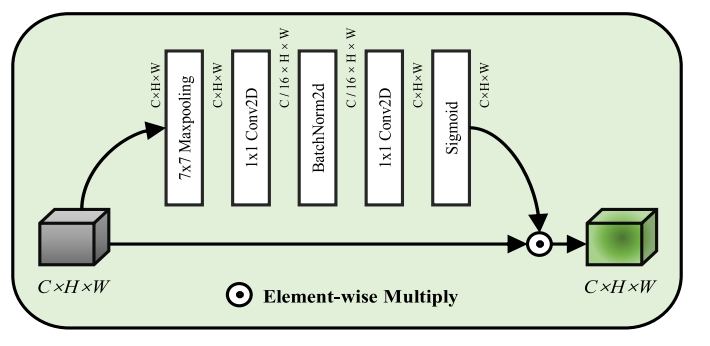

In [11]:
#| export
class EncoderModule(nn.Module):
    """
    Encoder module, is the agregation of 1 Basic encoder block followed by 1 CAM
    """
    def __init__(self, 
                 in_channels:int,
                 out_channels:int
                )->int: # output size of basic encoder block
        super(EncoderModule, self).__init__()
        self.encoder_block = BasicEncoderBlock(in_channels, out_channels)
        # in_channels of CAM is the out_shape of BasicEncoderBlock, see BasicEncoderBlock
        self.cam = CAM(out_channels)
        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        out = self.cam(self.encoder_block(x))
        x = self.avg_pool(out)

        return x, out

```{mermaid}
flowchart LR
    direction TB
    subgraph E["Encoder Module"]
        direction LR
        BasicEncoderBlock --> CAM
    end
    Input --> BasicEncoderBlock
    CAM --> Output
```

Here is an example on how to use it:

In [ ]:
input_encoder = torch.rand(4, 384, 32, 512)
encoder = EncoderModule(in_channels=384, out_channels=64)

out, outs_encoder = encoder(input_encoder)
print("Output shape:", out.shape)

Output shape: torch.Size([4, 64, 16, 256])


# Decoder
Transformer-based Balanced Non-square-Transformer Module (BNTM) is basicaly the implementation of the [swin tranformer](https://arxiv.org/abs/2103.14030) with some modifications

###  Balanced Non-square-Transformer Module

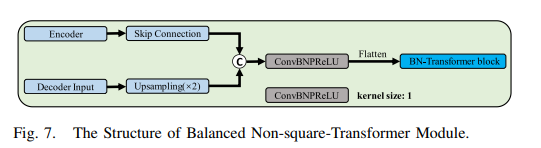

The Swin Transformer implementation is based on the code from TransRVNet's Swin Transformer module.
Source: [TransRVNet's Swin Transformer.py](https://github.com/huixiancheng/TransRVNet/blob/main/modules/swin_transformer.py)

In [ ]:
#| export
class GELU(nn.Module):
    """
    Activation function
    """
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(np.sqrt(2/np.pi)*(x+0.044715*torch.pow(x,3))))

In [ ]:
#| export
class MLP(nn.Module):
    """
    A simple Multilayer perceptron.
    """
    def __init__(self, 
                 in_features:int, # in
                 hidden_features:int=None, 
                 out_features:int=None, 
                 act_layer:nn.Module=nn.GELU, 
                 drop:int=0.
                ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)

        x = self.drop(x)
        return x

## Window basics

In [ ]:
#| export
def window_partition(x:torch.Tensor, # (B, H, W, C)
                     window_size:int # window size
                    )->torch.Tensor: # (num_windows\*B, window_size, window_size, C)
    """
    do something
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows


In [ ]:
#| export
def window_reverse(windows:torch.Tensor, # (num_windows*B, window_size, window_size, C)
                   window_size:int,      # Window size
                   H:int,                # Height of image
                   W:int                 # Width of image
                  )->torch.Tensor:       # (B, H, W, C)
    """
    do something 
    """
    B = int(windows.shape[0] / (H * W / window_size[0] / window_size[1]))
    x = windows.view(B, H // window_size[0], W // window_size[1], window_size[0], window_size[1], -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [ ]:
#| export
class WindowAttention(nn.Module):
    """ Window based multi-head self attention (W-MSA) module with relative position bias.
        It supports both of shifted and non-shifted window.
    """
    def __init__(self, 
                 dim:int,             # Number of input channels.
                 window_size:tuple,   # The height and width of the window. **(tuple of int)**
                 num_heads:int,       # Number of attention heads.
                 qkv_bias:bool=True,  # If True, add a learnable bias to query, key, value.
                 qk_scale:float=None, # Override default qk scale of **head_dim \*\* -0.5 if set**
                 attn_drop:float=0.,  # Dropout ratio of attention weight.
                 proj_drop:float=0.   # Dropout ratio of output.
                ):            
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5


        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2\*Wh-1 \* 2\*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh\*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh\*Ww, Wh\*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh\*Ww, Wh\*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, 
                x:torch.Tensor,              # input features with shape of (num_windows\*B, N, C)
                mask:torch.Tensor=None       # (0/-inf) mask with shape of (num_windows, Wh\*Ww, Wh\*Ww)
               )->torch.Tensor:              # Return x
        """
        Forward function.
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh\*Ww,Wh\*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh\*Ww, Wh\*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [ ]:
show_doc(WindowAttention.forward)

---

### WindowAttention.forward

>      WindowAttention.forward (x:torch.Tensor, mask:torch.Tensor=None)

Forward function.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| x | Tensor |  | input features with shape of (num_windows\*B, N, C) |
| mask | Tensor | None | (0/-inf) mask with shape of (num_windows, Wh\*Ww, Wh\*Ww) |
| **Returns** | **Tensor** |  | **Return x** |

## SwinTransformer

In [ ]:
#| export
# !pip install timm
# from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [ ]:
#| export
class SwinTransformerBlock(nn.Module):
    """ 
    Swin Transformer Block.
    """
    def __init__(self, 
                 dim:int,                            # Number of input channels.
                 num_heads:int,                      # Number of attention heads.
                 window_size:int=7,                  # Window size.
                 shift_size:int=0,                   # Shift size for SW-MSA.
                 mlp_ratio:float=4.,                 # Ratio of mlp hidden dim to embedding dim.
                 qkv_bias:bool=True,                 # If True, add a learnable bias to query, key, value.
                 qk_scale:float=None,                # Override default qk scale of **head_dim \*\* -0.5 if set**
                 drop:float=0.,                      # Dropout rate.
                 attn_drop:float=0.,                 # Attention dropout rate.
                 drop_path:float=0.,                 # Stochastic depth rate.
                 act_layer:nn.Module=nn.GELU,        # Activation layer.
                 norm_layer:nn.Module=nn.LayerNorm   # Normalization layer.
                ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        print(self.shift_size, self.window_size)
        assert 0 <= self.shift_size[0] < self.window_size[0], "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        print(self.drop_path)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.H = None
        self.W = None

    def forward(self, 
                x:torch.Tensor,           # Input feature, tensor size (B, H\*W, C).
                mask_matrix:torch.Tensor  # Attention mask for cyclic shift.
               ):
        """
        Forward function.
        """

        B, L, C = x.shape
        H, W = self.H, self.W

        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size[1] - W % self.window_size[1]) % self.window_size[1]
        pad_b = (self.window_size[0] - H % self.window_size[0]) % self.window_size[0]


        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))

        _, Hp, Wp, _ = x.shape

        # cyclic shift


        if self.shift_size[0] > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW\*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size[0] * self.window_size[1], C)  # nW*B, window_size\*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW\*B, window_size\*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size[0] > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size[0], self.shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

In [ ]:
show_doc(SwinTransformerBlock.forward)

---

### SwinTransformerBlock.forward

>      SwinTransformerBlock.forward (x:torch.Tensor, mask_matrix:torch.Tensor)

Forward function.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | Input feature, tensor size (B, H\*W, C). |
| mask_matrix | Tensor | Attention mask for cyclic shift. |

In [ ]:
#| export
class BNTM(nn.Module):
    """
    A basic Swin Transformer layer for one stage.
    """
    def __init__(self,
                 dim:int,                             # Number of feature channels
                 depth:int,                           # Depths of this stage.
                 num_heads:int,                       # Number of attention head.
                 window_size:int=7,                   # Local window size. 
                 minpatch:bool=False,                 # 
                 mlp_ratio:float=4.,                  # Ratio of mlp hidden dim to embedding dim.
                 qkv_bias:bool=True,                  # If True, add a learnable bias to query, key, value. 
                 qk_scale:float=None,                 # Override default qk scale of **head_dim \*\* -0.5 if set**
                 drop:float=0.,                       # Dropout rate. 
                 attn_drop:float=0.,                  # Attention dropout rate.
                 drop_path:float=0.,                  # Stochastic depth rate. 
                 norm_layer:nn.Module=nn.LayerNorm,   # Normalization layer.
                 downsample:nn.Module=None,           # nsample layer at the end of the layer. 
                 use_checkpoint:bool=False            # Whether to use checkpointing to save memory.
                ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = [int(i // 2) for i in window_size]  # Tamanho do deslocamento para SW-MSA
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # Construindo os blocos da camada
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=[0, 0] if (i % 2 == 0) or minpatch else self.shift_size,  # Window shift
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])  # Creating a Swin Transformer block for each depth

    def forward(self, 
                x:torch.Tensor, # Input feature, tensor size (B, H\*W, C).
                H:int,          # Height of the input image
                W:int           # Width of the input image
               ):
        """
        Forward function.
        """
        # Calculating the attention mask for SW-MSA
        Hp = int(np.ceil(H / self.window_size[0])) * self.window_size[0]
        Wp = int(np.ceil(W / self.window_size[1])) * self.window_size[1]
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # Initiate mask

        # Dividing the mask in slices
        h_slices = (slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None))
        w_slices = (slice(0, -self.window_size[1]),
                    slice(-self.window_size[1], -self.shift_size[1]),
                    slice(-self.shift_size[1], None))

        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt  # Assigning a unique value to each region
                cnt += 1

        # Partitioning the mask into windows
        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size[0] * self.window_size[1])
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        # Going through the blocks layers
        for blk in self.blocks:
            blk.H, blk.W = H, W  # Setting the resolution for the current block
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)  # Using a checkpoint to save memory
            else:
                x = blk(x, attn_mask)  # Passing the tensor and the attention mask through the block

        return x, H, W


In [ ]:
#| export
class SwinTransformer(nn.Module):
    def __init__(self,
                 embed_dim=64,
                 depths=[4, 4, 4, 4],
                 num_heads=[16, 8, 4, 2],
                 window_size=[4, 4],
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.0,
                 norm_layer=nn.LayerNorm,
                 patch_norm=True,
                 out_indices=(0, 1, 2, 3),
                 frozen_stages=-1,
                 use_checkpoint=False):
        super().__init__()

        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.out_indices = out_indices
        self.frozen_stages = frozen_stages

        # Setting up progressive dropout rate for residual paths
        dpr = [x.item() for x in torch.linspace(drop_path_rate, 0, sum(depths))]
        print(dpr)

        # Creating a list of modules for the layers of the Swin Transformer
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BNTM(
                dim=int(8 * embed_dim / 2**i_layer),  # Dimension of the embeddings of the layer
                depth=depths[i_layer],  # Number of blocks in the layer
                num_heads=num_heads[i_layer],  # Número de cabeças de atenção
                window_size=window_size,  # Size of the attention window
                minpatch=True if i_layer == 0 else False,  # Specific parameter for the first layer
                mlp_ratio=mlp_ratio,  # Expansion ratio of the MLP layer
                qkv_bias=qkv_bias,  # Bias in the QKV calculations
                qk_scale=qk_scale,  # Scaling factor for QKV
                drop=drop_rate,  # Dropout rate
                attn_drop=attn_drop_rate,  # Attention dropout rate
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # Progressive dropout
                norm_layer=norm_layer,  # Normalization layer
                use_checkpoint=use_checkpoint  # Checkpointing
            )
            self.layers.append(layer)

        # Defining the output feature dimensions for different layers
        num_features = [int(embed_dim * 2 ** i) for i in range(self.num_layers-1)][::-1]
        self.num_features = num_features

        # Linear layers for dimensionality reduction.
        self.redduce1 = nn.Linear(10*embed_dim, 4*embed_dim, bias=False)
        self.redduce2 = nn.Linear(9*embed_dim, 2*embed_dim, bias=False)
        self.redduce3 = nn.Linear(int(8.5*embed_dim), embed_dim, bias=False)

        # Normalization layers
        self.norm512 = nn.LayerNorm(8*embed_dim)
        self.norm256 = nn.LayerNorm(4*embed_dim)
        self.norm128 = nn.LayerNorm(2*embed_dim)
        self.norm64 = nn.LayerNorm(embed_dim)

        # Initializing the weights of the layers
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # Function to initialize the weights of the layers
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02) # Truncated normal initialization
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Bias initialization with zero
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)  # Bias initialization with zero
            nn.init.constant_(m.weight, 1.0) # Weight initialization with one

    def forward(self, x, out):
        """Forward function."""
        Wh, Ww = x.size(2), x.size(3) # Getting the height and width of the input
        x = x.flatten(2).transpose(1, 2) # Flattening and transposing the input
        x = self.norm512(x) # Normalizing the input
        x, Wh, Ww = self.layers[0](x, Wh, Ww) # Passing through the first layer

        x = x.view(-1, Wh, Ww, 8*self.embed_dim).permute(0, 3, 1, 2).contiguous() # Restructuring the output

        x = nn.PixelShuffle(2)(x)  # Increasing spatial resolution
        x = torch.cat([x, out[3]], dim=1).flatten(2).transpose(1, 2)  # Concatenating and restructuring
        x = self.redduce1(x)  # Reducing dimensionality
        x = torch.clamp(x, min=-65504, max=65504)  # Clipping tensor values
        x = self.norm256(x)  # Normalizing the output

        x, Wh, Ww = self.layers[1](x, 2 * Wh, 2 * Ww)  # Passing through the second layer
        x = x.view(-1, Wh, Ww, 4 * self.embed_dim).permute(0, 3, 1, 2).contiguous()  # Restructuring the output

        x = nn.PixelShuffle(2)(x)  # Increasing spatial resolution
        x = torch.cat([x, out[2]], dim=1).flatten(2).transpose(1, 2)  # Concatenating and restructuring
        x = self.redduce2(x)  # Reducing dimensionality
        x = self.norm128(x)   # Normalizing the output
        x, Wh, Ww = self.layers[2](x, 2 * Wh, 2 * Ww)  # Passing through the third layer

        x = x.view(-1, Wh, Ww, 2 * self.embed_dim).permute(0, 3, 1, 2).contiguous()  # Restructuring the output

        x = nn.PixelShuffle(2)(x)  # Increasing spatial resolution
        x = torch.cat([x, out[1]], dim=1).flatten(2).transpose(1, 2)  # Concatenating and restructuring
        x = self.redduce3(x)  # Reducing dimensionality
        x = self.norm64(x)  # Normalizing the output
        x, Wh, Ww = self.layers[3](x, 2 * Wh, 2 * Ww)  # Passing through the fourth layer

        return x

In [ ]:
#| export
class ConvDecoderBlock(nn.Module):
    """
    Convolution-based decoder block for the end of decoder pipeline
    """
    def __init__(self):
        super(ConvDecoderBlock, self).__init__()

        self.conv_3x3_1 = ConvBNPReLU(66, 32, kernel_size=3, padding=1)
        self.conv_3x3_2 = ConvBNPReLU(32, 16, kernel_size=3, padding=1)
        self.dilated_conv = ConvBNPReLU(16, 8, kernel_size=3, padding=2, dilation=2)
        self.conv_1x1 = ConvBNPReLU(64, 64, kernel_size=1)

    def forward(self, x1, x2):
        out = torch.cat((x1, x2), dim=1)

        out_conv_3x3_1 = self.conv_3x3_1(out)
        out_conv_3x3_2 = self.conv_3x3_2(out_conv_3x3_1)
        out_dilated_conv = self.dilated_conv(out_conv_3x3_2)

        out = torch.cat((out_conv_3x3_1, out_conv_3x3_2, out_dilated_conv, out_dilated_conv), dim=1)
        out = self.conv_1x1(out)

        return out

In [ ]:
show_doc(ConvDecoderBlock, title_level=2)

---

## ConvDecoderBlock

>      ConvDecoderBlock ()

final conv for process the tranformer

In [ ]:
show_doc(ConvDecoderBlock.forward, title_level=2)

---

## ConvDecoderBlock.forward

>      ConvDecoderBlock.forward (x1, x2)

Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.

In [ ]:
#|export 
class Decoder(nn.Module):
    def __init__(self, window_size):
        super(Decoder, self).__init__()
        self.bntm = SwinTransformer(window_size=window_size, embed_dim=8)
        self.upsample = nn.PixelShuffle(upscale_factor=2)
        self.conv_decoder_block = ConvDecoderBlock()
        self.seg_head = ConvBNPReLU(64, N_CLASSES, kernel_size=1)

    def forward(self, x, outs):
        out = self.bntm(x, outs)
        out = out.view(-1, 32, 512,  8).permute(0, 3, 1, 2).contiguous()
        out = self.upsample(out)
        out = self.conv_decoder_block(out, outs[0])
        out = self.seg_head(out)
        return out

# TransRVNet

The main class takes 3 input images.

In [ ]:
class TransVRNet(nn.Module):
    """
    """
    def __init__(self, window_size=(4,4), N_CLASSES=20):
        super(TransVRNet, self).__init__()
        self.mrciam = MRCIAM()

        self.encoder_module1 = EncoderModule(384, 64)
        self.encoder_module2 = EncoderModule(64, 64)

        self.decoder = Decoder(window_size=window_size, N_CLASSES=N_CLASSES)

    def forward(self, x1, x2, x3):
        # MRCIAM
        out_mrciam = self.mrciam(x1, x2, x3)

        # Enconder modules
        x, out_encoder1 = self.encoder_module1(out_mrciam)
        x, out_encoder2 = self.encoder_module2(x)
        x, out_encoder3 = self.encoder_module2(x)
        x, out_encoder4 = self.encoder_module2(x)

        outs_encoder = [out_encoder1, out_encoder2, out_encoder3, out_encoder4]

        out = self.decoder(x, outs_encoder)

        return out

In [ ]:
reflectance_tensor = torch.randn(1, 1, 64, 1024)
depth_tensor = torch.randn(1, 1, 64, 1024)
xyz_tensor = torch.randn(1, 3, 64, 1024)

model = TransVRNet()

out = model(reflectance_tensor, depth_tensor, xyz_tensor)
print("Output shape:", out.shape)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()